## Decision Trees and Random Forest
### Predicting High Future Healthcare Costs

**Using high future healthcare expenditures as a proxy for worsening health, this decision tree model will predict whether or not someone's health is expected to worsen in the future. The goal in predicting this is that if physicians and medicare service providers can predict someone's future health to decline, they can offer that beneficiary preventative services.**

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(11, 4)})

In [105]:
claims = pd.read_csv('claimsFull.csv')

claims['reimb2010'].describe()

count    1.023952e+06
mean     2.843428e+03
std      5.959792e+03
min      0.000000e+00
25%      2.400000e+02
50%      1.120000e+03
75%      2.620000e+03
max      1.605000e+05
Name: reimb2010, dtype: float64

**We define "high" healthcare costs as costs that are above the 75th percentile of medicare benficiaries.**

In [91]:
claims['High Cost'] = claims.reimb2010.apply(lambda x: 1 if x >= 2.620000e+03 else 0)

claims.head()

,reimb2010,reimb2008,reimb2009,age2010,male,race,heart.failure,kidney,cancer,copd,...,EyeExam,EKG,xray,CTScan,PhysicalTherapy,Ambulance,acuity,costTrend,monthsWithClaims,High Cost
0,390,320.0,360,97,0,White,0,0,0,0,...,1,0,1,0,0,0,0.235294,-0.018856,9,0
1,970,58800.0,2740,79,0,White,1,1,0,1,...,0,2,8,1,0,1,0.853591,-0.027265,21,0
2,5630,510.0,1580,87,0,White,1,0,0,0,...,0,1,2,1,1,0,0.175115,0.496742,20,1
3,3480,2930.0,49330,79,0,White,1,1,0,1,...,1,1,6,4,3,3,0.709147,0.214955,19,1
4,920,1500.0,1650,85,1,White,1,0,1,0,...,2,1,3,0,1,0,0.174603,0.231568,21,0


In [102]:
def log_transform(dataframe, variables):
    '''
    Takes a log transformation of variables
    
    Inputs: variables (list of variables to log transform)
            dataframe (claims dataframe)
    '''
    for var in variables:
        dataframe["log("+var+'+ 1)'] = np.array(dataframe[var]) + 1
        dataframe["log("+var+'+ 1)'] = np.log10(dataframe["log("+var+'+ 1)'])
        dataframe = dataframe.drop(columns = [var])
    return dataframe

In [106]:
claims = log_transform(claims, ['reimb2010','reimb2009','reimb2008'])

Note: The last column appears to be processed.
Will remove this column because otherwise it dominates the CART model

In [94]:
claims = claims.drop(columns = ['monthsWithClaims'])

In [95]:
claims.columns

Index(['age2010', 'male', 'race', 'heart.failure', 'kidney', 'cancer', 'copd',
       'depression', 'diabetes', 'ihd', 'osteoporosis', 'arthritis', 'stroke',
       'InpatientClaims', 'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG',
       'xray', 'CTScan', 'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'High Cost', 'log(reimb2010+ 1)', 'log(reimb2009+ 1)',
       'log(reimb2008+ 1)'],
      dtype='object')

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [110]:
train, test = train_test_split(claims, test_size=0.2, random_state=0)

labels = train[['log(reimb2009+ 1)', 'log(reimb2008+ 1)',
               'acuity', 'kidney', 'InpatientClaims', 'costTrend']].columns.values

X_train = train[['log(reimb2009+ 1)', 'log(reimb2008+ 1)',
               'acuity', 'kidney', 'InpatientClaims', 'costTrend']].values

y_train = train['High Cost'].values

X_test = test[['log(reimb2009+ 1)', 'log(reimb2008+ 1)',
               'acuity', 'kidney', 'InpatientClaims', 'costTrend']].values

y_test = test['High Cost'].values

In [111]:
pipeline = Pipeline([("dec_tree", DecisionTreeClassifier(random_state = 0))])

In [112]:
criterion = ["gini", "entropy"]
max_depth = [1, 3, 5]
min_samples_split = [2, 5, 10]
parameters = {
    "dec_tree__criterion" : criterion,
    "dec_tree__max_depth" : max_depth,
    "dec_tree__min_samples_split" : min_samples_split
}

In [113]:
grid_model = GridSearchCV(estimator=pipeline, 
                          param_grid=parameters, 
                          cv=10,
                          return_train_score=True,
                          scoring='accuracy',
                          iid=True)

In [114]:
grid_model_result = grid_model.fit(X_train, y_train)

high_cost = grid_model.predict(X_test)

/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [115]:
mse_grid = metrics.mean_squared_error(y_test, high_cost)

print("""
MSE (Grid Search):\t{}
""".format(mse_grid))

cv_results = pd.DataFrame(grid_model.cv_results_)
ranked_cv = cv_results.sort_values(by='mean_train_score', ascending = False)


MSE (Grid Search):	0.23897534559624203



In [116]:
ranked_cv.loc[6].params

{'dec_tree__criterion': 'gini',
 'dec_tree__max_depth': 5,
 'dec_tree__min_samples_split': 2}

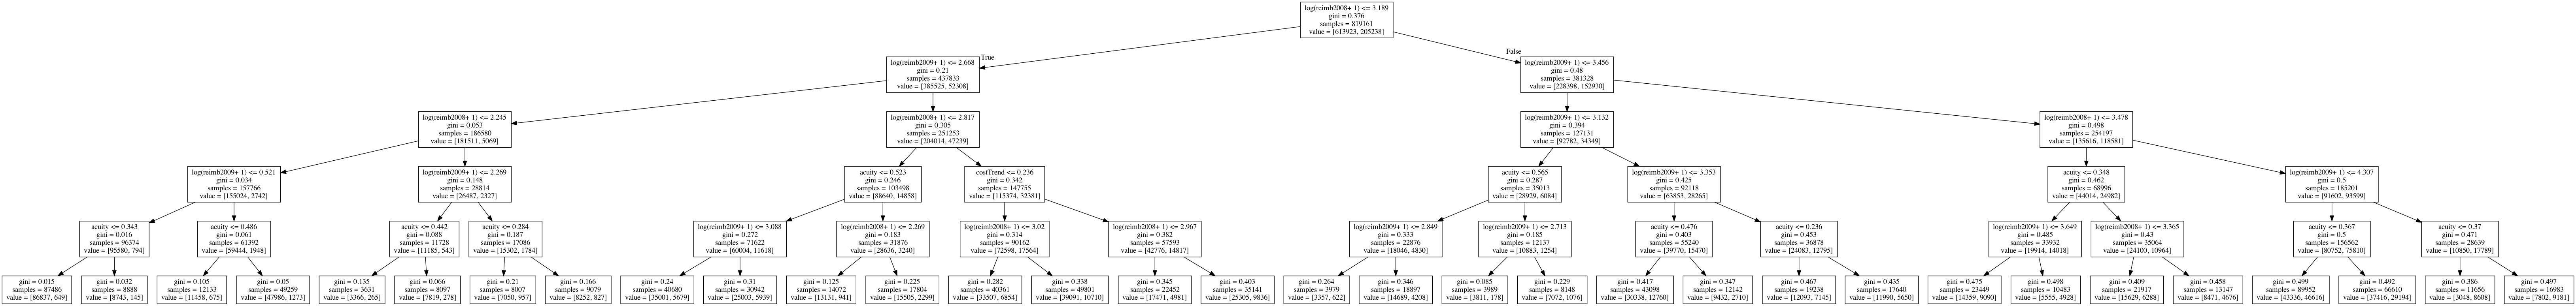

In [84]:
from sklearn import tree
import pydotplus
from IPython.display import Image

dt = DecisionTreeClassifier(random_state=0,max_depth=5, criterion = "gini", min_samples_split = 2)
model = dt.fit(X_train, y_train)

dot_data = tree.export_graphviz(dt, out_file=None, feature_names=labels)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [120]:
y_pred = dt.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[139787  13554]
 [ 35386  16064]]
              precision    recall  f1-score   support

           0       0.80      0.91      0.85    153341
           1       0.54      0.31      0.40     51450

    accuracy                           0.76    204791
   macro avg       0.67      0.61      0.62    204791
weighted avg       0.73      0.76      0.74    204791



In [119]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)
disp = plot_precision_recall_curve(dt, X_test, y_test)
disp.ax_.set_title("Precision-Recall Curve")

## Random Forest

In [125]:
claims_sample = claims.sample(frac=0.02, random_state=0)

train, test = train_test_split(claims_sample, test_size=0.2, random_state=0)

labels = train[['log(reimb2009+ 1)', 'log(reimb2008+ 1)',
               'acuity', 'kidney', 'InpatientClaims', 'costTrend']].columns.values

X_train = train[['log(reimb2009+ 1)', 'log(reimb2008+ 1)',
               'acuity', 'kidney', 'InpatientClaims', 'costTrend']].values

y_train = train['High Cost'].values

X_test = test[['log(reimb2009+ 1)', 'log(reimb2008+ 1)',
               'acuity', 'kidney', 'InpatientClaims', 'costTrend']].values

y_test = test['High Cost'].values

In [126]:
pipeline_rf = Pipeline([("rand_forest", RandomForestClassifier(random_state = 0))])

n_estimators = [100, 1000, 5000]
max_depth = [1, 3, 5]
min_samples_split = [2, 5, 10]
parameters3 = {
    "rand_forest__n_estimators" : n_estimators,
    "rand_forest__max_depth" : max_depth,
    "rand_forest__min_samples_split" : min_samples_split
}

In [127]:
grid_model_rf = GridSearchCV(estimator=pipeline_rf, 
                          param_grid=parameters3, 
                          cv=10,
                          return_train_score=True,
                          scoring='accuracy')

grid_model_result = grid_model_rf.fit(X_train, y_train)

cv_results_rf = pd.DataFrame(grid_model_rf.cv_results_)

cv_results_rf.columns

ranked_cv_rf = cv_results_rf.sort_values(by=['rank_test_score'])

In [129]:
ranked_cv_rf.loc[21].params

{'rand_forest__max_depth': 5,
 'rand_forest__min_samples_split': 5,
 'rand_forest__n_estimators': 100}

In [130]:
rf = grid_model_rf.best_estimator_[0]

model = rf.fit(X_train, y_train)

In [131]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      3130
           1       0.61      0.15      0.24       966

    accuracy                           0.78      4096
   macro avg       0.70      0.56      0.56      4096
weighted avg       0.75      0.78      0.72      4096

